In [1]:
!unzip '/content/drive/My Drive/27Class.zip'

Streaming output truncated to the last 5000 lines.
  inflating: 27Class/97888/00011.jpg  
  inflating: 27Class/97888/00021.jpg  
  inflating: 27Class/97888/00007.jpg  
  inflating: 27Class/97888/00009.jpg  
  inflating: 27Class/97888/00013.jpg  
  inflating: 27Class/97888/00005.jpg  
  inflating: 27Class/97888/00001.jpg  
   creating: 27Class/81065/
  inflating: 27Class/81065/00017.jpg  
  inflating: 27Class/81065/00015.jpg  
  inflating: 27Class/81065/00023.jpg  
  inflating: 27Class/81065/00019.jpg  
  inflating: 27Class/81065/00003.jpg  
  inflating: 27Class/81065/00011.jpg  
  inflating: 27Class/81065/00021.jpg  
  inflating: 27Class/81065/00007.jpg  
  inflating: 27Class/81065/00009.jpg  
  inflating: 27Class/81065/00013.jpg  
  inflating: 27Class/81065/00005.jpg  
  inflating: 27Class/81065/00001.jpg  
   creating: 27Class/89905/
  inflating: 27Class/89905/00017.jpg  
  inflating: 27Class/89905/00015.jpg  
  inflating: 27Class/89905/00023.jpg  
  inflating: 27Class/89905/00019.jp

In [3]:
import pandas as pd
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import CSVLogger
import math
import random

In [4]:
LABELS={
    "Swiping Left":                     0,
    "Swiping Right":                    1,
    "Swiping Down":                     2,
    "Swiping Up":                       3,
    "Pushing Hand Away":                4,
    "Pulling Hand In":                  5,
    "Sliding Two Fingers Left":         6,
    "Sliding Two Fingers Right":        7,
    "Sliding Two Fingers Down":         8,
    "Sliding Two Fingers Up":           9,
    "Pushing Two Fingers Away":         10,
    "Pulling Two Fingers In":           11,
    "Rolling Hand Forward":             12,
    "Rolling Hand Backward":            13,
    "Turning Hand Clockwise":           14,
    "Turning Hand Counterclockwise":    15,
    "Zooming In With Full Hand":        16,
    "Zooming Out With Full Hand":       17,
    "Zooming In With Two Fingers":      18,
    "Zooming Out With Two Fingers":     19,
    "Thumb Up":                         20,
    "Thumb Down":                       21,
    "Shaking Hand":                     22,
    "Stop Sign":                        23,
    "Drumming Fingers":                 24,
    "No gesture":                       25,
    "Doing other things":               26,

}

class readData():
    def __init__(self,
                 p_train='/content/drive/My Drive/csv27class/train.csv',
                 p_validation='/content/drive/My Drive/csv27class/valid.csv'):
        
        self.p_train      = p_train
        self.p_validation = p_validation
        self.readCSV()

    def readCSV(self):
        #Olusturulan pathlerden CSV dosyalarini okur
        print("Reading CSV Files")
        self.validationCSV = pd.read_csv(self.p_validation,header=None)
        self.trainCSV      = pd.read_csv(self.p_train,header=None)
        print("Reading CSV Files is Completed")

    def getDict(self):
        #Train ve Validation videolarının idlerini tutar
        #partition{'train': ['id-1', 'id-2', 'id-3'], 'validation': ['id-4']}
        #labels{'id-1': 0, 'id-2': 1, 'id-3': 2, 'id-4': 1}
        print("Creating Dictionaries")
        partition = {
            "train": self.trainCSV.get(0).values,
            "validation": self.validationCSV.get(0).values
        }
        labels={}
        print("Creating Train/Validation Labels")
        print("Adding Train Labels")
        for i in partition['train']:
            labels[i]=LABELS[self.trainCSV[self.trainCSV[0]==i][1].values[0]]
        print("Adding Validation Labels")
        for i in partition['validation']:
            labels[i]=LABELS[self.validationCSV[self.validationCSV[0]==i][1].values[0]]
        print("Completed")

        return partition,labels

In [5]:
class dataLoader(tf.keras.utils.Sequence):
    def __init__(self,list_IDs,labels,batchSize=16,dim=(12,150,100),nChannel=3,nClass=27,shuffle=True):
        self.dim = dim                  # Her batchte alınacak verinin boyutu Frame Sayısı * Width * Height
        self.batch_size = batchSize     # Batch boyutu
        self.labels = labels            # Classların labelları
        self.list_IDs = list_IDs        # Batch leri belirleyecek CSV train/validation csv
        self.n_channels = nChannel      # Resimdeki kanal sayısı RGB=3
        self.n_classes = nClass         # Class sayısı
        self.shuffle = shuffle          # Batchteki verileri karıştırır.
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # for dongusu icinde sonraki batch icin gesture örneklerini ve labellarını cek.
        # örnekleri ve altındaki tüm frameleri cekmek icin ekstra bir fonksiyona ihtiyac var.

        for i, ID in enumerate(list_IDs_temp):
            X[i] = self.sample_reader(ID)
            y[i] = self.labels[ID]

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

    #Her bir videonun framelerini okur ve tek örnek döner
    #validation için ayrıca bir if else koyarak validation partitionda /valid den çek
    def sample_reader(self,id):
        # batchsize,framenumber,h,w,channel
        x = np.zeros((12, 150, 100, 3), dtype='uint8');
        i = 0
        for img in os.listdir('./27Class/' + str(id)):
            image = cv2.imread("./27Class/" + str(id) + "/" + str(img))
            image = cv2.resize(image, (100,150))
            x[i] = image
            i += 1
        return x

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):

        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

In [6]:
from tensorflow.keras.layers import ReLU,GlobalMaxPooling2D
from tensorflow.keras.layers import *

def createModel():
    model=tf.keras.Sequential()

    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=32,padding='same',strides=1),input_shape=(12,150,100,3)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())

    model.add(TimeDistributed(MaxPooling2D((2,2),strides=(1,1),data_format='channels_last')))

    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=64,padding='same',strides=1)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())

    model.add(TimeDistributed(MaxPooling2D((2,2),strides=(2,2),data_format='channels_last')))

    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=128,padding='same',strides=1)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())

    model.add(TimeDistributed(MaxPooling2D((2,2),strides=(2,2),data_format='channels_last')))


    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=256,padding='same',strides=1)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())

    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=256,padding='same',strides=1)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())

    model.add(TimeDistributed(MaxPooling2D((2,2),strides=(2,2),data_format='channels_last')))

    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=512,padding='same',strides=1)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())

    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=512,padding='same',strides=1)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())

    model.add(TimeDistributed(MaxPooling2D((2,2),strides=(2,2),data_format='channels_last')))


    model.add(TimeDistributed(Conv2D(kernel_size=(3,3),filters=1024,padding='same',strides=1)))
    model.add(TimeDistributed(LeakyReLU(0.01)))
    model.add(BatchNormalization())

    model.add(TimeDistributed(GlobalMaxPooling2D()))
    model.add(TimeDistributed(Dropout(0.4)))
    

    model.add(TimeDistributed(Dense(1024)))
    model.add(LSTM(1024))
    model.add(Dense(27,activation ='softmax'))


    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                      optimizer=tf.keras.optimizers.SGD(lr=0.01),
                      metrics=['accuracy'])
    model.summary()


    return model
createModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 12, 150, 100, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 150, 100, 32)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 150, 100, 32)  128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 12, 149, 99, 32)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 12, 149, 99, 64)   18496     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 12, 149, 99, 64)   0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 149, 99, 64)   2

In [13]:
data_csv=readData()
partition,labels=data_csv.getDict()

training_data=dataLoader(partition['train'],labels,15,(12,150,100),3,27,True)
validation_data=dataLoader(partition['validation'],labels,15,(12,150,100),3,27,False)

Reading CSV Files
Reading CSV Files is Completed
Creating Dictionaries
Creating Train/Validation Labels
Adding Train Labels
Adding Validation Labels
Completed


In [21]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/My Drive/Complete Models/27Class/model27class_{epoch:02d}.h5", monitor='acc', verbose=1,
                                                save_best_only=False, mode='auto',save_freq='epoch')

csv_logger = CSVLogger("/content/drive/My Drive/Complete Models/27Class/model27class_history_log.csv", append=True)

def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)



#model=createModel()
model=tf.keras.models.load_model("/content/drive/My Drive/Complete Models/27Class/model27class_11.h5")


model.fit(x=training_data,
                    validation_data=validation_data,
                    epochs=50,callbacks=[checkpoint,csv_logger,lrate],verbose=1,initial_epoch=11)



Epoch 12/50
  28/7885 [..............................] - ETA: 3:17:43 - loss: 0.2980 - accuracy: 0.9214

KeyboardInterrupt: ignored

#Evaluate

In [14]:
model=tf.keras.models.load_model("/content/drive/My Drive/Complete Models/27Class/model27class_11.h5")
y_pred = model.predict_generator(validation_data,985,verbose=1)
y_pred = np.argmax(y_pred,axis=1)

985/985 [==============================] - 463s 470ms/step


In [15]:
y_pred

array([20, 10,  0, ...,  4,  6, 20])

In [16]:
y_true=pd.read_csv("/content/drive/My Drive/csv27class/valid.csv",header=None)[1].values[0:14775]
for i,label in enumerate(y_true):
  y_true[i] = LABELS[label]

y_true

array([20, 10, 0, ..., 4, 6, 24], dtype=object)

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true2=np.array(y_true,dtype=np.uint32)
y_pred2=np.array(y_pred,dtype=np.uint32)

print(classification_report(y_true2, y_pred2, target_names=LABELS27))

                               precision    recall  f1-score   support

                 Swiping Left       0.80      0.79      0.80       494
                Swiping Right       0.80      0.83      0.81       484
                 Swiping Down       0.89      0.85      0.87       520
                   Swiping Up       0.81      0.80      0.81       507
            Pushing Hand Away       0.90      0.89      0.89       538
              Pulling Hand In       0.82      0.82      0.82       526
     Sliding Two Fingers Left       0.88      0.86      0.87       519
    Sliding Two Fingers Right       0.90      0.83      0.86       515
     Sliding Two Fingers Down       0.84      0.74      0.79       531
       Sliding Two Fingers Up       0.73      0.81      0.77       522
     Pushing Two Fingers Away       0.87      0.86      0.86       531
       Pulling Two Fingers In       0.90      0.88      0.89       518
         Rolling Hand Forward       0.64      0.72      0.68       521
     

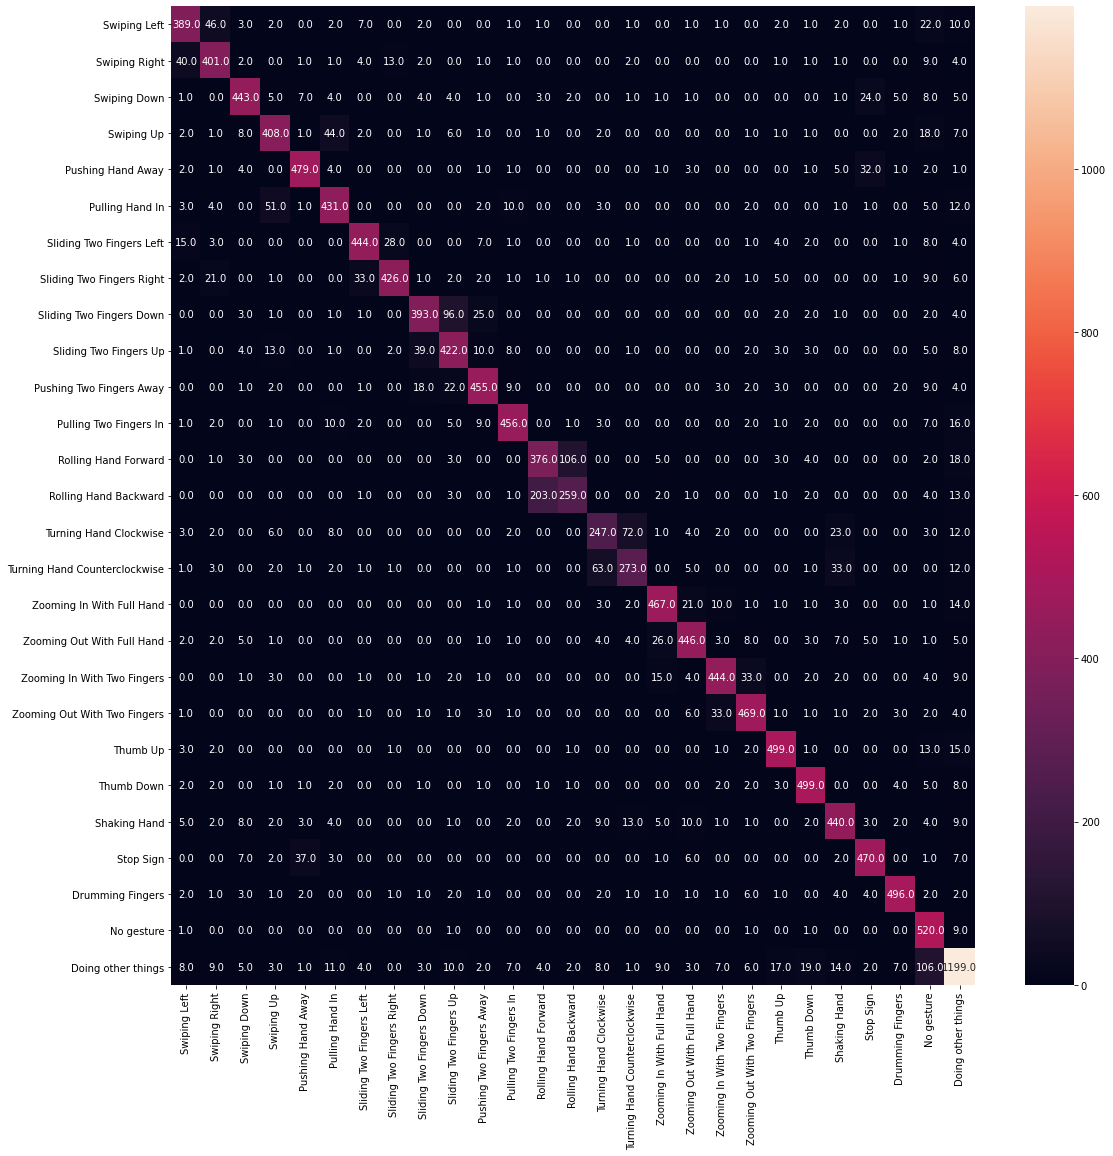

In [19]:
LABELS27=[
    "Swiping Left",
    "Swiping Right",
    "Swiping Down",
    "Swiping Up",
    "Pushing Hand Away",
    "Pulling Hand In",
    "Sliding Two Fingers Left",
    "Sliding Two Fingers Right",
    "Sliding Two Fingers Down",
    "Sliding Two Fingers Up",
    "Pushing Two Fingers Away",
    "Pulling Two Fingers In",
    "Rolling Hand Forward",
    "Rolling Hand Backward",
    "Turning Hand Clockwise",
    "Turning Hand Counterclockwise",
    "Zooming In With Full Hand",
    "Zooming Out With Full Hand",
    "Zooming In With Two Fingers",
    "Zooming Out With Two Fingers",
    "Thumb Up",
    "Thumb Down",
    "Shaking Hand",
    "Stop Sign",
    "Drumming Fingers",
    "No gesture",
    "Doing other things",
]
matrix = confusion_matrix(y_true2, y_pred2)
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, xticklabels=True, yticklabels=True,fmt=".1f")
ax.figure.set_size_inches(18,18)
ax.xaxis.set_ticklabels(LABELS27,rotation=90); ax.yaxis.set_ticklabels(LABELS27,rotation=0);
